# IRRIGATION ADVICE 

In [66]:
import import_ipynb
import datetime
import pandas
import json
import requests
from numpy import nan
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from matplotlib import dates as mdate
from sklearn.linear_model import LinearRegression
from IPython.display import Image
pandas.options.display.float_format = '{:,.3f}'.format
from BabiloniaDataAnalyticsOffline import BabiloniaDataAnalyticsOffline

#WEATHER_KEY secret
WEATHER_KEY = None
with open('../../server/app/config.json') as json_data_file:
    data = json.load(json_data_file)
    WEATHER_KEY = data["WEATHER_KEY"]

In [74]:
# CONSTANTS

MOISTURE_PROBES = ['MUX0','MUX1','MUX2','MUX3','MUX4','MUX5','MUX6','MUX7']
ROLLING_WINDOW = 30 # RUPTURE_LEVEL_THRESHOLD and PCT_CHANGE_PERIOD are affected by this value
RUPTURE_LEVEL_THRESHOLD = 0.015
PCT_CHANGE_PERIOD = 10 # RUPTURE_LEVEL_THRESHOLD is affected by this value
HEARTBEAT_PERIOD=30 # (seconds) OMG 2 heartbeats
MOISTURE_DATA_PERIOD = 2*3600 # (seconds)
PRECIPITATION_FORECAST_TIME_AHEAD= 2*3600
PRECIPITATION_PROBABILITY_THRESHOLD=0.25
LATEST_LEVEL_CHECK_WINDOW=30
LATEST_LEVEL_CHECK_QUANTILE=0.5

# FUNCTIONS

def plot(series): 
    plt.rcParams['figure.figsize'] = [15,7]
    plt.rcParams['timezone'] = 'America/Sao_Paulo'

    fig,ax = plt.subplots()
    x = mdate.epoch2num(series.index)
    fmt = mdate.DateFormatter('%y-%m-%d %H:%M')

    ax.xaxis.set_major_formatter(fmt)
    plt.xticks( rotation=25 )
    plt.plot_date(x, series, linestyle='solid', marker='None')
    plt.legend(MOISTURE_PROBES)
    plt.show()
    
def filter_noise_in_moisture_data_cache(data):
    return data.rolling(ROLLING_WINDOW).mean().dropna()
    
def detect_rupture_oasis(data):
    #Percentage change between the current and a prior element
    # Finding negative or positive slopes ...
    # percent change over given number of period.
    pct_change_series = data.pct_change(periods=PCT_CHANGE_PERIOD).dropna()
    ### Gathering data
    ruptures={}
    min_probes={}
    max_probes={}
    for mux in MOISTURE_PROBES:
        min_entry={}
        min_entry['epoch'] = pct_change_series[mux].idxmin()
        min_entry['value'] = pct_change_series[mux][min_entry['epoch']]
        if min_entry['value'] < -RUPTURE_LEVEL_THRESHOLD:
            min_probes[mux] = min_entry

        max_entry={}
        max_entry['epoch'] = pct_change_series[mux].idxmax()
        max_entry['value'] = pct_change_series[mux][max_entry['epoch']]
        if max_entry['value'] > RUPTURE_LEVEL_THRESHOLD:
            max_probes[mux] = max_entry
    ruptures['downward'] = pandas.DataFrame(data=min_probes).T
    ruptures['upward'] =  pandas.DataFrame(data=max_probes).T
    return ruptures

def get_latest_moisture_level(data):
    return data.tail(LATEST_LEVEL_CHECK_WINDOW).quantile(LATEST_LEVEL_CHECK_QUANTILE).round(0).astype(int)

def linear_regressor(data):
    X = data.index.to_numpy().reshape(-1, 1)
    entries={}
    for mux in MOISTURE_PROBES:
        Y = data[mux].values.reshape(-1, 1)
        linear_regressor = LinearRegression()  # create object for the class
        linear_regressor.fit(X, Y)  # perform linear regression
        Y_pred = linear_regressor.predict(X)  # make predictions
        entry={}
        entry['score']=linear_regressor.score(X,Y)
        entry['coef'] =linear_regressor.coef_[0][0]
        entries[mux] = entry
    result = pandas.DataFrame(data=entries).T # transpose
    return result

def will_rain(now, display):
    will_rain = False
    lat = -22.019989
    long = -47.312531
    hourly_forecast={}
    try:
        response = requests.get(
        'https://api.forecast.io/forecast/%s/%s,%s,%s?units=si&lang=pt&exclude=currently,flags,alerts,daily'
        %(WEATHER_KEY, lat, long,now))
        data = response.json()
        hourly_forecast = pandas.DataFrame(data=data["hourly"]["data"])
        hourly_forecast.set_index('time', inplace=True)
        hourly_forecast_filtered = hourly_forecast[(hourly_forecast.index >= now ) & (hourly_forecast.index < now + PRECIPITATION_FORECAST_TIME_AHEAD)]
        will_rain = len(hourly_forecast_filtered[
                        (hourly_forecast_filtered['precipProbability'] >= PRECIPITATION_PROBABILITY_THRESHOLD) |
                        (hourly_forecast_filtered['icon'] == 'rain')]) > 0
    except requests.ConnectionError:
        self.logger.debug("[will_rain] ConnectionError!!!")
    if display:
        return hourly_forecast_filtered
    return will_rain

In [3]:
bda = BabiloniaDataAnalyticsOffline("./moisture_data_1604935353_1609325379.pkl")
bda.plot_node_moisture()

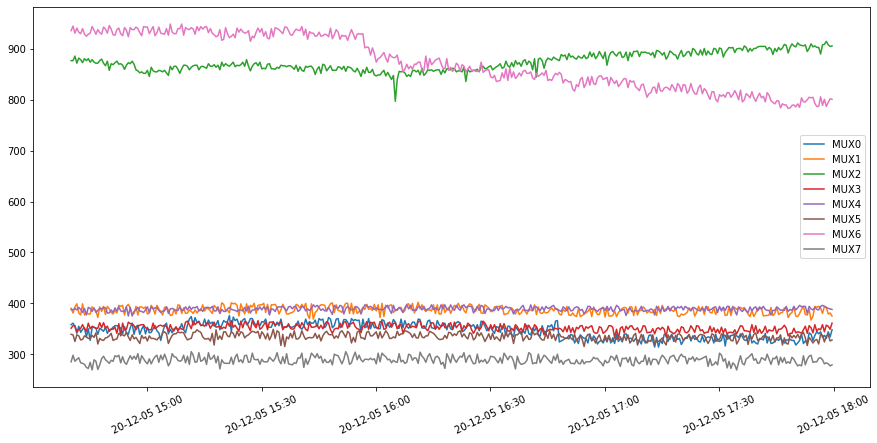

In [57]:
#TEST DATA
moisture_data = bda.NODE_MOISTURE_DATA[(bda.NODE_MOISTURE_DATA.index >= bda.START_TIME) & (bda.NODE_MOISTURE_DATA.index <= bda.NOW)]
plot(moisture_data)

In [58]:
latest_moisture_level = get_latest_moisture_level(moisture_data)
latest_moisture_level

MUX0    330
MUX1    382
MUX2    906
MUX3    349
MUX4    390
MUX5    332
MUX6    792
MUX7    284
Name: 0.5, dtype: int64

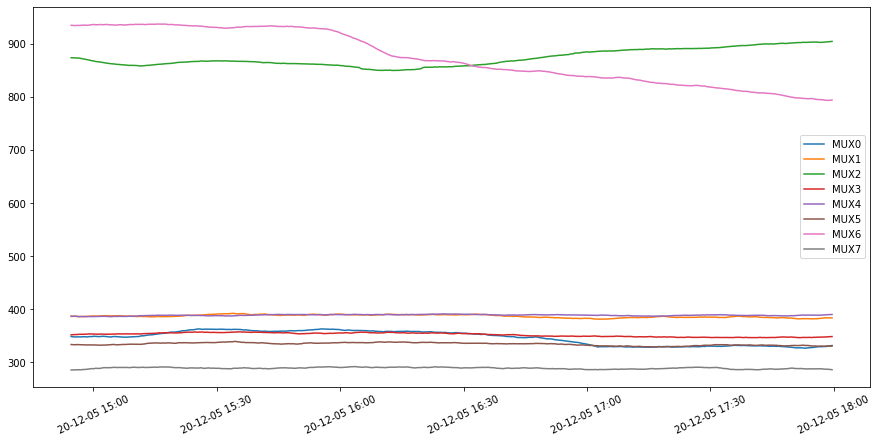

In [59]:
data_noise_filtered = filter_noise_in_moisture_data_cache(moisture_data)
plot(data_noise_filtered)

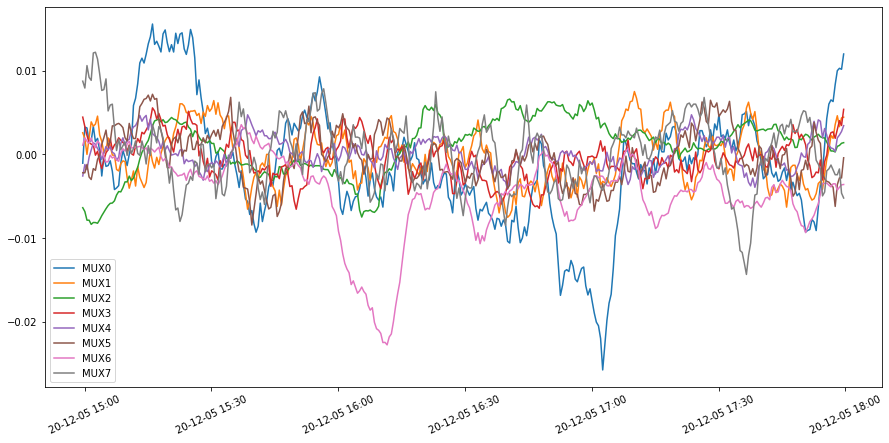

In [83]:
plot(data_noise_filtered.pct_change(periods=PCT_CHANGE_PERIOD).dropna())

In [79]:
ruptures = detect_rupture_oasis(data_noise_filtered)
ruptures['downward']

,epoch,value
MUX0,"1,607,198,554.000",-0.026
MUX6,"1,607,195,494.000",-0.023


In [80]:
ruptures['upward']

,epoch,value
MUX0,"1,607,192,164.000",0.016


In [81]:
alpha = linear_regressor(data_noise_filtered)
alpha

,score,coef
MUX0,0.648,-0.003
MUX1,0.397,-0.001
MUX2,0.626,0.004
MUX3,0.721,-0.001
MUX4,0.028,0.000
MUX5,0.383,-0.001
MUX6,0.953,-0.015
MUX7,0.178,-0.000


In [78]:
will_rain(bda.NOW, False)

True

In [ ]:
#MUX_PORT_THRESHOLD
OFFLINE=50
WET=350
NOSOIL=680